In [3]:
cd ..

/Users/katherineharvey/sparse-probing-4


In [4]:
%matplotlib inline


%load_ext autoreload
%autoreload 2


import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sns
import copy
from argparse import Namespace


from torch.utils.data import DataLoader
import transformer_lens
import datasets

from load import *

from analysis.load_results import (
    load_probing_experiment_results,
    load_probing_experiment_results_old,
    make_heuristic_probing_results_df
)
from probing_datasets.language_id import NATURAL_LANGS_UNABBREVIATED

from activations.activation_subset import load_activation_subset, load_neuron_subset_csv
from analysis.plots import *


from einops import rearrange, reduce, repeat

import statistics as stat





In [5]:
model_name = 'pythia-70m'
dataset_name = 'natural_lang_id.pyth.512.-1'
experiment_name = 'language_monosemantic'

neurons, neuron_df = load_neuron_subset_csv(Namespace(model=model_name, neuron_subset_file='monosemantic_language_neurons.csv'), return_df=True)
act_subset_dict, metadata, token_summary_df = load_activation_subset('results', model_name, dataset_name, experiment_name, 'activation_subset')
feature_dataset = load_feature_dataset(dataset_name)
model = load_model('pythia-70m') # only need tokenizer so load smallest model

/Users/katherineharvey/sparse-probing-4/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


## High level questions
* Are the language neurons firing on any stimuli unrelated to the relevant language?
* For two language neurons of the same language, what are they doing different? Why the need for duplication?

A little bit of starter code and useful data structures to get you going:

In [6]:
neuron_df

,layer,neuron,feature
0,4,627,Italian
1,5,1434,Greek
2,4,230,Swedish
3,3,1817,Swedish
4,3,609,French
5,3,533,Italian
6,3,343,German
7,5,894,German
8,5,395,English
9,4,179,English


In [7]:
layer_ix, neuron_ix, feature = neuron_df.iloc[2]
n_seqs, ctx_len = feature_dataset['tokens'].shape

# preactivations (before we apply the GeLU) for every token in the feature dataset (europarl)
# ie, same shape as feature_dataset['tokens']

# make a 

activations_1 = act_subset_dict[4, 627]
activations_2 = act_subset_dict[5, 1434]
activations_3 = act_subset_dict[4, 230]
activations_4 = act_subset_dict[3, 1817]
activations_5 = act_subset_dict[3, 609]
activations_6 = act_subset_dict[3, 533]
activations_7 = act_subset_dict[3, 343]
activations_8 = act_subset_dict[5, 894]
activations_9 = act_subset_dict[5, 395]
activations_10 = act_subset_dict[4, 179]

# {token_id: token_string}
decoded_vocab = {t: model.tokenizer.decode(t) for t in model.tokenizer.get_vocab().values()}

activation_df_italian1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_1.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_greek1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_2.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})


activation_df_swedish1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_3.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_swedish2 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_4.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})


activation_df_french1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_5.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_italian2 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_6.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_german1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_7.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_german2 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_8.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_english1 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_9.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})

activation_df_english2 = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations_10.flatten().numpy().astype(np.float16),
    'language_id': np.concatenate([(np.ones(ctx_len) * c.item()).astype(np.uint8) for c in feature_dataset['class_ids']]),
    'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})


language = ['Spanish', 'English', 'French', 'Dutch', 'Italian', 'Greek', 'German', 'Portuguese', 'Swedish']
language_id = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
# A flattened version of the feature dataset (rows concatenated together)
# with the token, the corresponding activation, and the language id, and the token string
activation_df_italian1.query('language_id == 2').head()

,token,activation,language_id,string
4155392,1,0.107422,2,<|padding|>
4155393,253,-2.015625,2,the
4155394,2791,-1.343750,2,market
4155395,15,0.135254,2,.
4155396,187,-1.126953,2,\n


In [14]:
small_italiadf1 = activation_df_italian1.query('activation < -2')

In [15]:
small_italiadf1

,token,activation,language_id,string
8,1602,-2.849609,4,beh
11,3889,-3.185547,4,van
15,1888,-2.777344,4,vers
17,3889,-3.080078,4,van
18,399,-3.402344,4,D
...,...,...,...,...
18917542,5346,-2.001953,6,β
18918431,10227,-2.021484,6,δ
18918567,33887,-2.027344,6,υ
18918809,37849,-2.025391,6,Σ


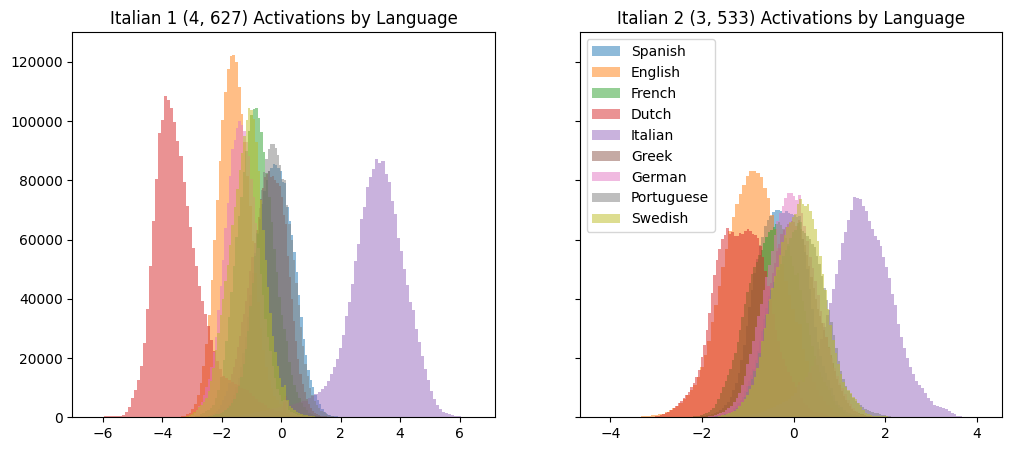

In [227]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i in range(len(language)):
    l = language_id[i]
    ax1.hist(activation_df_italian1.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax1.set_title("Italian 1 (4, 627) Activations by Language");


for i in range(len(language)):
    l = language_id[i]
    ax2.hist(activation_df_italian2.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax2.set_title("Italian 2 (3, 533) Activations by Language");
ax1.set_ylim(0, 130000);
ax2.legend();

In [ ]:
# italian and spanish are "similar", but spanish doesn't have a high activation on the italian neurons, in comparison to dutch, 
# swedish, and german 

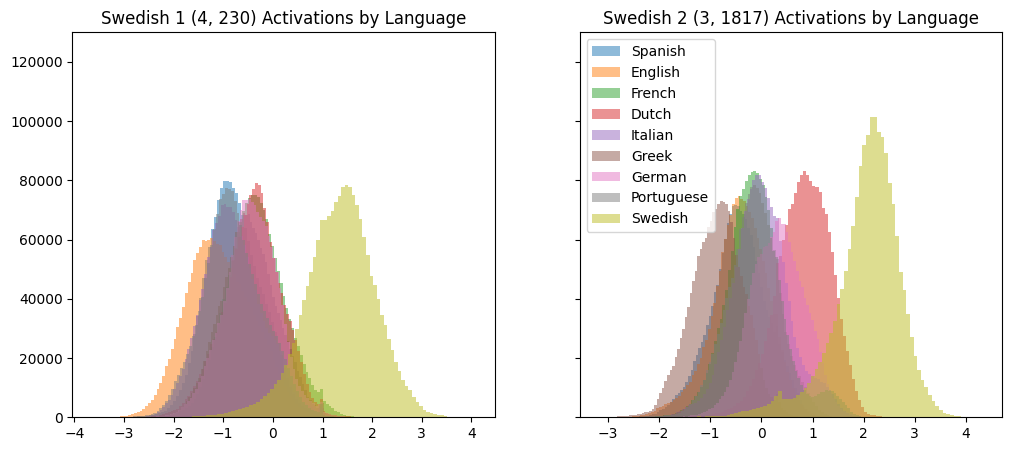

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i in range(len(language)):
    l = language_id[i]
    ax1.hist(activation_df_swedish1.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax1.set_title("Swedish 1 (4, 230) Activations by Language");


for i in range(len(language)):
    l = language_id[i]
    ax2.hist(activation_df_swedish2.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax2.set_title("Swedish 2 (3, 1817) Activations by Language");
ax1.set_ylim(0, 130000);
ax2.legend();

Text(0.5, 0.98, 'Correlation Plots of Language Activations')

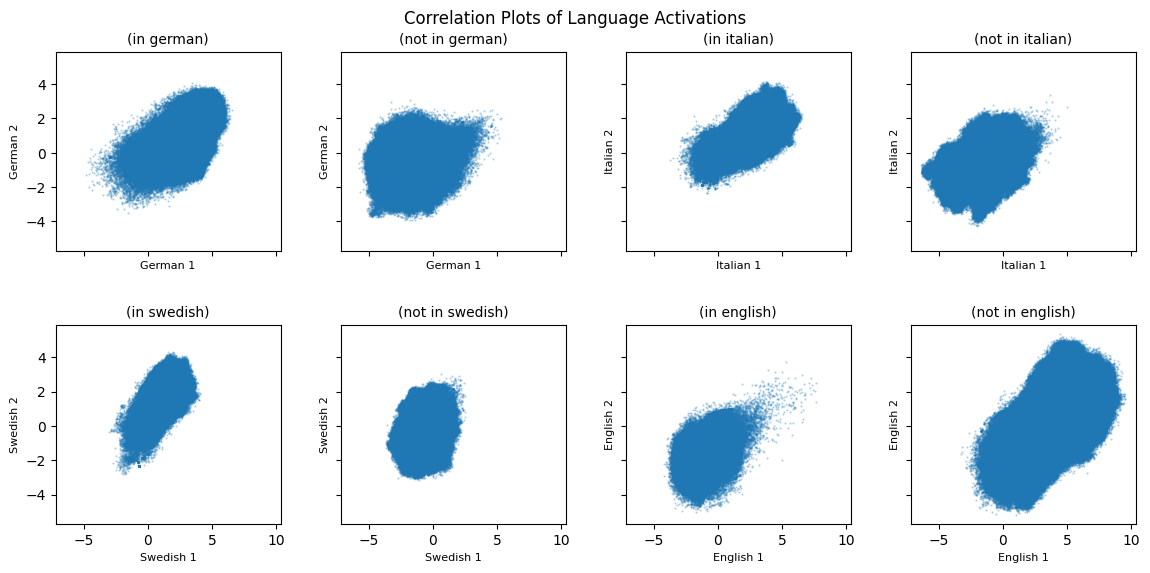

In [59]:
import matplotlib.pyplot as plt

# Create a 2x4 grid of subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)

# Plot the correlation plots in each subplot
axs[0, 0].scatter(activation_df_german1.query('language_id == 7')['activation'], activation_df_german2.query('language_id == 7')['activation'], s=.5, alpha=0.25)
axs[0, 0].set_title("(in german)", fontsize=10)
axs[0, 0].set_xlabel('German 1', fontsize=8)
axs[0, 0].set_ylabel('German 2', fontsize=8)

axs[0, 1].scatter(activation_df_german1.query('language_id != 7')['activation'], activation_df_german2.query('language_id != 7')['activation'], s=.5, alpha=0.25)
axs[0, 1].set_title("(not in german)", fontsize=10)
axs[0, 1].set_xlabel('German 1', fontsize=8)
axs[0, 1].set_ylabel('German 2', fontsize=8)

axs[0, 2].scatter(activation_df_italian1.query('language_id == 5')['activation'], activation_df_italian2.query('language_id == 5')['activation'], s=.5, alpha=0.25)
axs[0, 2].set_title("(in italian)", fontsize=10)
axs[0, 2].set_xlabel('Italian 1', fontsize=8)
axs[0, 2].set_ylabel('Italian 2', fontsize=8)

axs[0, 3].scatter(activation_df_italian1.query('language_id != 5')['activation'], activation_df_italian2.query('language_id != 5')['activation'], s=.5, alpha=0.25)
axs[0, 3].set_title("(not in italian)", fontsize=10)
axs[0, 3].set_xlabel('Italian 1', fontsize=8)
axs[0, 3].set_ylabel('Italian 2', fontsize=8)

axs[1, 0].scatter(activation_df_swedish1.query('language_id == 9')['activation'], activation_df_swedish2.query('language_id == 9')['activation'], s=.5, alpha=0.25)
axs[1, 0].set_title("(in swedish)", fontsize=10)
axs[1, 0].set_xlabel('Swedish 1', fontsize=8)
axs[1, 0].set_ylabel('Swedish 2', fontsize=8)

axs[1, 1].scatter(activation_df_swedish1.query('language_id != 9')['activation'], activation_df_swedish2.query('language_id != 9')['activation'], s=.5, alpha=0.25)
axs[1, 1].set_title("(not in swedish)", fontsize=10)
axs[1, 1].set_xlabel('Swedish 1', fontsize=8)
axs[1, 1].set_ylabel('Swedish 2', fontsize=8)


axs[1, 2].scatter(activation_df_english1.query('language_id == 2')['activation'], activation_df_english2.query('language_id == 2')['activation'], s=.5, alpha=0.25)
axs[1, 2].set_title("(in english)", fontsize=10)
axs[1, 2].set_xlabel('English 1', fontsize=8)
axs[1, 2].set_ylabel('English 2', fontsize=8)

axs[1, 3].scatter(activation_df_english1.query('language_id != 2')['activation'], activation_df_english2.query('language_id != 2')['activation'], s=.5, alpha=0.25)
axs[1, 3].set_title("(not in english)", fontsize=10)
axs[1, 3].set_xlabel('English 1', fontsize=8)
axs[1, 3].set_ylabel('English 2', fontsize=8)


fig.tight_layout(pad=2.5)
fig.suptitle("Correlation Plots of Language Activations")


In [61]:
activation_df_english2.query('language_id != 2')['activation'].max()


5.363

In [ ]:
activation_df_german1, activation_df_german2,activation_df_italian1, activation_df_italian2, activation_df_swedish1, 
activation_df_swedish2, activation_df_english1, activation_df_english2

In [8]:
dataframes = {
    'German 1 Activation Median': activation_df_german1,
    'German 2 Activation Median': activation_df_german2,
    'Greek 1 Activation Median': activation_df_greek1,
    'Italian 1 Activation Median': activation_df_italian1,
    'italian 2 Activation Median': activation_df_italian2,
    'Swedish 1 Activation Median': activation_df_swedish1,
    'Swedish 2 Activation Median': activation_df_swedish2,
    'English 1 Activation Median': activation_df_english1,
    'English 2 Activation Median': activation_df_english2,
    'French Activation Median': activation_df_french1
}

median_activation = {}
for lang_id, df in dataframes.items():
    median_activation[lang_id] = df.groupby('language_id')['activation'].median()

median_activation_df = pd.DataFrame(median_activation)
median_activation_df.index = language
median_activation_df


,German 1 Activation Mean,German 2 Activation Mean,Greek 1 Activation Mean,Italian 1 Activation Mean,italian 2 Activation Mean,Swedish 1 Activation Mean,Swedish 2 Activation Mean,English 1 Activation Mean,English 2 Activation Mean,French Activation Mean
Spanish,-2.111328,-0.835449,-1.318359,-0.371826,-0.397461,-0.666504,-0.313477,4.625000,0.423340,-1.042969
English,-1.811523,-0.831543,-1.607422,-1.449219,-0.710449,-0.930664,-0.268555,-1.590820,-1.725586,-1.392578
French,-1.619141,-0.969238,-1.126953,-0.734863,-0.525391,-0.236572,-0.068054,4.507812,0.381592,3.080078
Dutch,-0.783203,-0.676758,-1.711914,-3.380859,-1.000977,-0.275879,0.747070,3.164062,0.169556,-0.922852
Italian,-1.430664,-0.106750,-1.429688,3.074219,1.340820,-0.729492,0.085327,4.015625,0.179565,-1.307617
Greek,-1.931641,-0.624512,2.263672,-0.400635,-0.090698,-0.416260,-0.769531,1.758789,-0.496094,-1.379883
German,3.222656,1.191406,-1.481445,-1.197266,-0.190918,-0.301270,0.449219,3.164062,-0.076233,-1.158203
Portuguese,-2.044922,-0.336426,-1.239258,-0.333252,0.025696,-0.735840,-0.035492,4.667969,0.389893,-1.257812
Swedish,-1.306641,-0.044800,-1.608398,-1.044922,0.039398,1.264648,2.050781,3.429688,0.358887,-3.703125


In [155]:
dataframes = [activation_df_german1, activation_df_german2, activation_df_greek1, activation_df_italian1, activation_df_italian2, activation_df_swedish1, activation_df_swedish2, activation_df_english1, activation_df_english2, activation_df_french1]
modes = ['German 1', 'German 2', 'Greek', 'Italian 1', 'Italian 2', 'Swedish 1', 'Swedish 2', 'English 1', 'English 2', 'French']

mode_dfs = []
for i, df in enumerate(dataframes):
    mode_list = []
    for l in language_id:
        data = df.query('language_id == @l and token > 1')['activation']
        hist, bins = np.histogram(data, bins=100)
        top_bin_idx = np.argmax(hist)
        mode_list.append((bins[top_bin_idx], bins[top_bin_idx+1]))
    
    mode_df = pd.DataFrame({modes[i] + ' Activation Mode': mode_list}, index=language)
    mode_dfs.append(mode_df)

# Concatenate all mode DataFrames along columns
all_modes_df = pd.concat(mode_dfs, axis=1)
all_modes_df

,German 1 Activation Mode,German 2 Activation Mode,Greek Activation Mode,Italian 1 Activation Mode,Italian 2 Activation Mode,Swedish 1 Activation Mode,Swedish 2 Activation Mode,English 1 Activation Mode,English 2 Activation Mode,French Activation Mode
Spanish,"(-2.307, -2.2)","(-0.59, -0.526)","(-1.634, -1.545)","(-0.2908, -0.2126)","(-0.4163, -0.3586)","(-0.938, -0.878)","(-0.5254, -0.4749)","(6.508, 6.63)","(1.735, 1.831)","(-1.179, -1.067)"
English,"(-2.045, -1.936)","(-0.5747, -0.505)","(-1.789, -1.697)","(-1.642, -1.55)","(-0.97, -0.8936)","(-1.262, -1.204)","(-0.464, -0.4111)","(-1.842, -1.724)","(-1.954, -1.867)","(-1.603, -1.495)"
French,"(-1.754, -1.657)","(-0.9355, -0.873)","(-1.441, -1.354)","(-0.87, -0.785)","(-0.3503, -0.2976)","(-0.4407, -0.3828)","(-0.1566, -0.10156)","(6.566, 6.69)","(1.13, 1.223)","(3.416, 3.545)"
Dutch,"(-0.722, -0.62)","(-0.583, -0.521)","(-1.905, -1.813)","(-3.932, -3.828)","(-1.474, -1.417)","(-0.3604, -0.3037)","(0.82, 0.8794)","(4.16, 4.26)","(0.3066, 0.398)","(-0.742, -0.635)"
Italian,"(-1.655, -1.563)","(0.0367, 0.098)","(-1.701, -1.614)","(3.166, 3.27)","(1.294, 1.359)","(-0.994, -0.938)","(-0.05945, -0.002266)","(6.375, 6.5)","(1.4375, 1.533)","(-1.3545, -1.261)"
Greek,"(-2.11, -2.018)","(-0.1334, -0.0746)","(2.36, 2.467)","(-0.4397, -0.3694)","(0.08704, 0.1339)","(-0.611, -0.561)","(-0.8086, -0.7593)","(1.553, 1.647)","(-1.15, -1.067)","(-1.432, -1.342)"
German,"(3.596, 3.71)","(1.656, 1.732)","(-1.624, -1.537)","(-1.4375, -1.357)","(-0.0824, -0.02313)","(-0.5015, -0.445)","(0.3247, 0.375)","(4.934, 5.043)","(0.2837, 0.3704)","(-1.17, -1.07)"
Portuguese,"(-2.139, -2.04)","(-0.2651, -0.1996)","(-1.534, -1.443)","(-0.2983, -0.2214)","(0.1209, 0.1736)","(-0.972, -0.912)","(-0.1625, -0.1082)","(6.14, 6.266)","(1.365, 1.467)","(-1.303, -1.197)"
Swedish,"(-1.38, -1.289)","(0.1, 0.162)","(-1.735, -1.6455)","(-1.114, -1.034)","(0.1215, 0.1768)","(1.447, 1.519)","(2.188, 2.26)","(4.664, 4.76)","(-0.505, -0.4036)","(-4.02, -3.914)"


Top bin range: (-2.307, -2.2)
Frequency of top bin: 106988


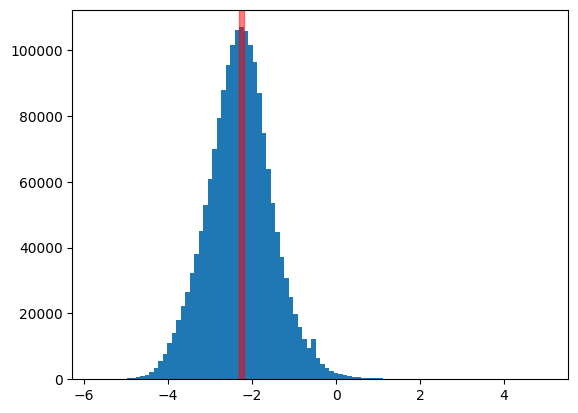

In [156]:
data = activation_df_german1.query('language_id == 1 and token > 1')['activation'] 
hist, bins = np.histogram(data, bins=100)
top_bin_idx = np.argmax(hist)

# access the range of values for the top bin
top_bin_range = (bins[top_bin_idx], bins[top_bin_idx+1])

# print the range of values and the frequency of the top bin
print("Top bin range:", top_bin_range)
print("Frequency of top bin:", hist[top_bin_idx])

# plot the histogram with the top bin highlighted
plt.hist(data, bins=100)
plt.axvspan(top_bin_range[0], top_bin_range[1], alpha=0.5, color='red')
plt.show()

In [111]:
# IGNORE
pd.concat([mode_s1_df, mode_s2_df, mode_i1_df, mode_greek1_df, mode_f1_df, mode_i2_df, mode_german1_df, mode_german2_df, mode_e1_df, mode_e2_df.reindex(mode_s1_df.index)], axis=1)

,Swedish 1 Activation Mode,Swedish 2 Activation Mode,Italian 1 Activation Mode,Greek 1 Activation Mode,French 1 Activation Mode,Italian 2 Activation Mode,German 1 Activation Mode,German 2 Activation Mode,English 1 Activation Mode,English 2 Activation Mode
Spanish,0.766602,0.552246,-0.392090,-1.016602,-0.927246,-0.536133,-0.785156,-0.954590,0.895996,0.975586
English,0.751465,0.562988,0.107422,-1.045898,-0.924805,-0.541992,-0.785645,-0.971191,0.892090,0.975586
French,0.770996,0.547363,0.107422,-1.003906,-0.928711,-0.535156,-0.785645,-0.950684,0.896484,0.975586
Dutch,0.767578,0.552246,0.107422,-1.020508,-0.927246,-0.536133,-0.784668,-0.954102,0.896484,0.975586
Italian,0.768555,0.551270,0.107422,-1.011719,-0.925293,-0.535645,-0.787109,-0.953125,0.896484,0.975586
Greek,0.764160,0.552246,-0.391113,-1.008789,-0.926758,-0.537109,-0.793457,-0.953613,0.895508,0.975586
German,0.766113,0.549316,-0.389893,-1.018555,-0.928223,-0.536133,-0.793945,-0.952148,0.895996,0.975586
Portuguese,0.754395,0.562988,0.107422,-1.058594,-0.924805,-0.539551,-0.783203,-0.964355,0.892090,0.975586
Swedish,0.759277,0.558594,0.107422,-1.036133,-0.925293,-0.539062,-0.786133,-0.962891,0.894531,0.975586


In [90]:
lst = [1, 2, 3]
lst[:0]

[]

In [112]:
# what does max mena for this?
activation_df_swedish1.max()

token             50276
activation     4.089844
language_id           9
string               ��
dtype: object

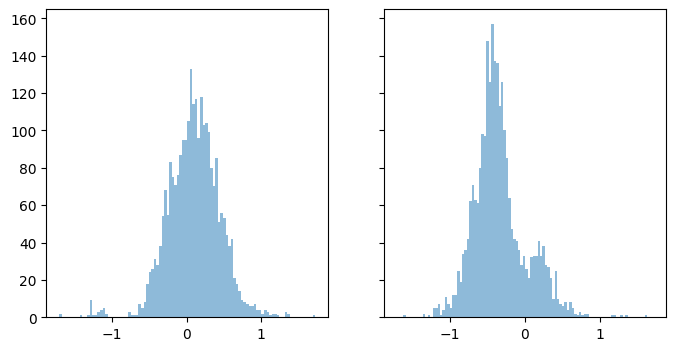

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)

ax1.hist(activation_df_swedish1.query('token == 50276')['activation'], bins=100, alpha=0.5);
ax2.hist(activation_df_swedish2.query('token == 50276')['activation'], bins=100, alpha=0.5);

In [132]:
activation_df_swedish1.sort_values('activation', ascending=True).head(2000)

,token,activation,language_id,string
5300412,2773,-3.654297,2,That
5058630,2064,-3.644531,2,That
4582204,2773,-3.642578,2,That
5327720,2064,-3.626953,2,That
7525928,406,-3.585938,1,oc
...,...,...,...,...
5956475,347,-2.982422,2,as
4856036,406,-2.982422,2,oc
5069239,347,-2.982422,2,as
5803927,310,-2.982422,2,is


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)

ax1.hist(activation_df_swedish1.query('token == 310')['activation'], bins=30, alpha=0.5);
ax1.set_title("Swedish Neuron 1 (4, 230)");
ax2.hist(activation_df_swedish2.query('token == 310')['activation'], bins=30, alpha=0.5);
ax2.set_title("Swedish Neuron 2 (3, 1817)");
fig.suptitle("Token 31217 (\"is\")");

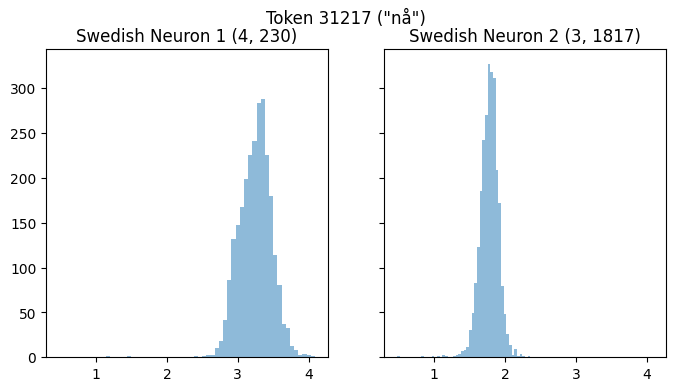

In [140]:
# checking to see if activations are consistent
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)

ax1.hist(activation_df_swedish1.query('token == 31217')['activation'], bins=50, alpha=0.5);
ax1.set_title("Swedish Neuron 1 (4, 230)");
ax2.hist(activation_df_swedish2.query('token == 31217')['activation'], bins=50, alpha=0.5);
ax2.set_title("Swedish Neuron 2 (3, 1817)");
fig.suptitle("Token 31217 (\"nå\")");

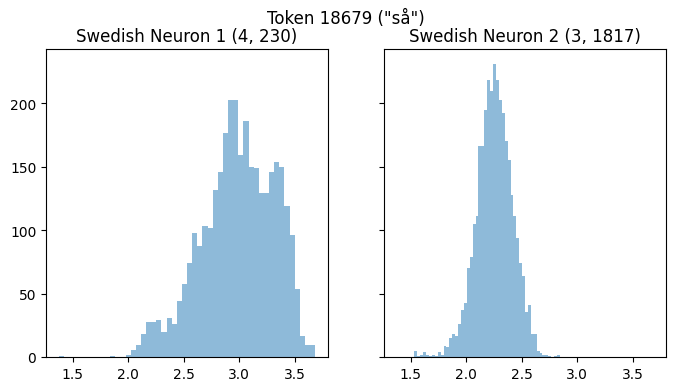

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True, sharex=True)

ax1.hist(activation_df_swedish1.query('token == 18679')['activation'], bins=50, alpha=0.5);
ax1.set_title("Swedish Neuron 1 (4, 230)");
ax2.hist(activation_df_swedish2.query('token == 18679')['activation'], bins=50, alpha=0.5);
ax2.set_title("Swedish Neuron 2 (3, 1817)");
fig.suptitle("Token 18679 (\"så\")");

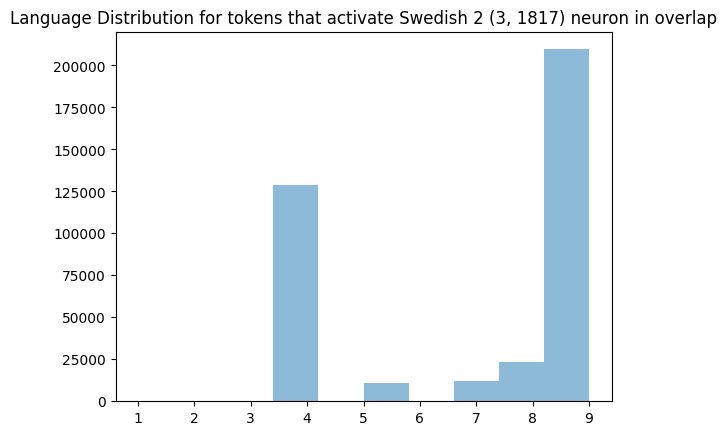

In [126]:
plt.hist(activation_df_swedish2.query('activation > 1.5 and activation < 1.8')['language_id'], alpha=0.5);
plt.title("Language Distribution for tokens that activate Swedish 2 (3, 1817) neuron in overlap");

# for reference
# language = ['Spanish', 'English', 'French', 'Dutch', 'Italian', 'Greek', 'German', 'Portuguese', 'Swedish']
# language_id = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [60]:
activation_df_swedish1.query('language_id == 2').max()

token             50276
activation     2.042969
language_id           2
string                �
dtype: object

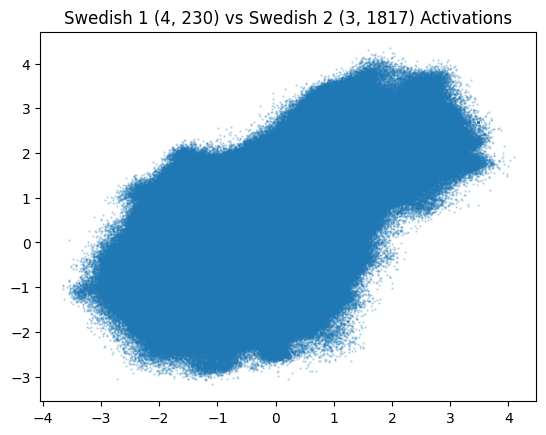

In [57]:
# shows us that they are pretty similar
# are the sparse areas around the blob j noise or are they worth investigating?
plt.scatter(activation_df_swedish1['activation'], activation_df_swedish2['activation'], s=.5, alpha=0.25);
plt.title("Swedish 1 (4, 230) vs Swedish 2 (3, 1817) Activations");

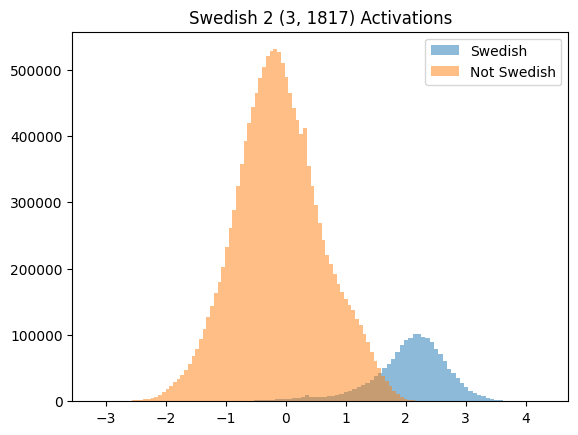

In [58]:
in_swedish = activation_df_swedish2.query('language_id == 9 and token > 1')['activation']
not_swedish = activation_df_swedish2.query('language_id != 9 and token > 1')['activation']
plt.hist(in_swedish, bins=100, alpha=0.5, label='Swedish');
plt.hist(not_swedish, bins=100, alpha=0.5, label='Not Swedish');
plt.title("Swedish 2 (3, 1817) Activations");
plt.legend();


In [ ]:
# swedish 2 neuron appears earlier in the network yet the distinction between languages is less clear

In [30]:
# dataframe of in dutch 
# would be cool to see how the strong dutch neuron performs on this set of tokens 
np.unique(np.array(activation_df_swedish2.query('language_id == 9')['token']))


array([    0,     1,     2, ..., 50249, 50275, 50276], dtype=uint16)

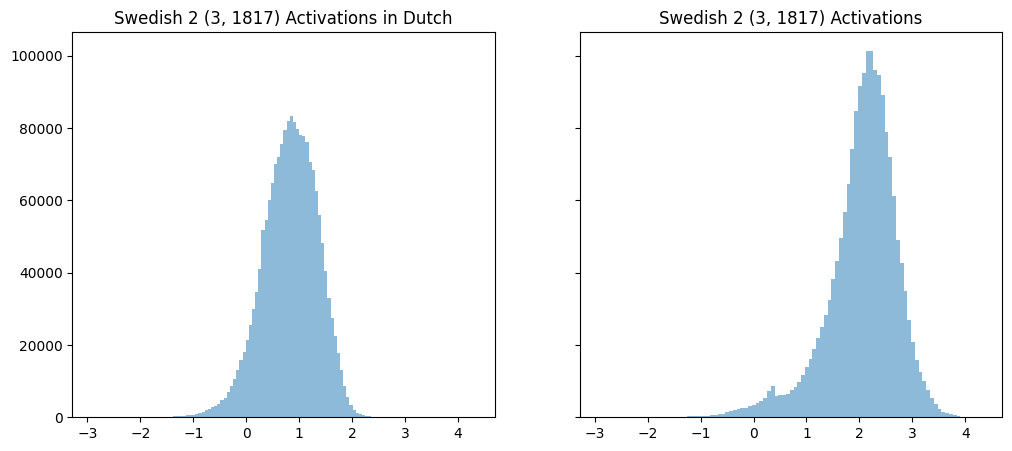

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True, sharex=True)

ax1.hist(activation_df_swedish2.query('language_id == 4 & token > 1')['activation'], bins=100, alpha=0.5);
ax1.set_title("Swedish 2 (3, 1817) Activations in Dutch");
ax2.hist(activation_df_swedish2.query('language_id == 9 & token > 1')['activation'], bins=100, alpha=0.5);
ax2.set_title("Swedish 2 (3, 1817) Activations");

In [90]:
high_dutch = np.array(activation_df_swedish2.query('language_id == 9 & token > 1 & activation > 1')['token'])
high_dutch[:1000]
# these are positive activating tokens for the swedish neuron in dutch
# could try to figure out why these tokens are signficant for the swedish neuron?


array([  863, 38980,   376, 41164,  3807, 23537, 16361,  7005,   372,
        5674,  5021,  1682,  1392,  2188,  1241, 34685,   428,  1260,
         298,   468,  4267,   428, 34045,   275, 49980,  1392,   376,
         863,  3779,  2375,   804,   257,  1323, 13096,   701, 10120,
       10273,  1331,   267,  1794,   301,  5551,    76,   350,    87,
        8919,   356,  3372,    13, 20442,  7151, 34045,  3977,    66,
        7357,   546,   278, 36212,    69,  1502,  1392,    72,  7271,
          66,  4112,   254,    32, 11752, 39966,    72, 40406,    84,
       17911,   257,   270,  6592,  5674,   437, 16653,   296,  2094,
         920,  7357,  1392,  2503,   284, 10647,   546,  6446,  2768,
        9747, 39966,    87,   518,   920,  1323,  1850,  2072,   946,
       50019,  1616,    79,  6594,   339,  5751,   263,    15,  4597,
       14710,   891, 41164,  1775,  1342, 12109, 21098,   307,   297,
       28574,  1378,   863,   417,  3525,   863,  2177,   270,  6592,
       45844, 31051,

In [93]:
activation_df_german1.query('token ==  16361')

,token,activation,language_id,string
2120713,16361,0.094910,9,jag
2121757,16361,-1.479492,9,jag
2121838,16361,-1.297852,9,jag
2121852,16361,-1.170898,9,jag
2122122,16361,-1.402344,9,jag
...,...,...,...,...
4154384,16361,-1.250000,9,jag
4154674,16361,-1.188477,9,jag
4154788,16361,-1.183594,9,jag
4154876,16361,-1.053711,9,jag


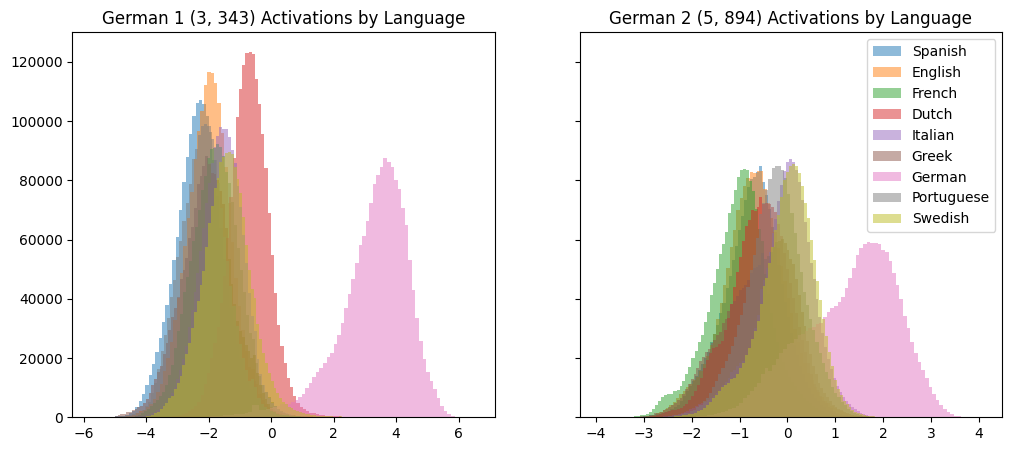

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i in range(len(language)):
    l = language_id[i]
    ax1.hist(activation_df_german1.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax1.set_title("German 1 (3, 343) Activations by Language");


for i in range(len(language)):
    l = language_id[i]
    ax2.hist(activation_df_german2.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax2.set_title("German 2 (5, 894) Activations by Language");
ax1.set_ylim(0, 130000);
ax2.legend();

In [ ]:
# dutch is similar to german so it make sense for the dutch pile to be slightly higher?, but it still does a good job of distinguishing 
# between languages

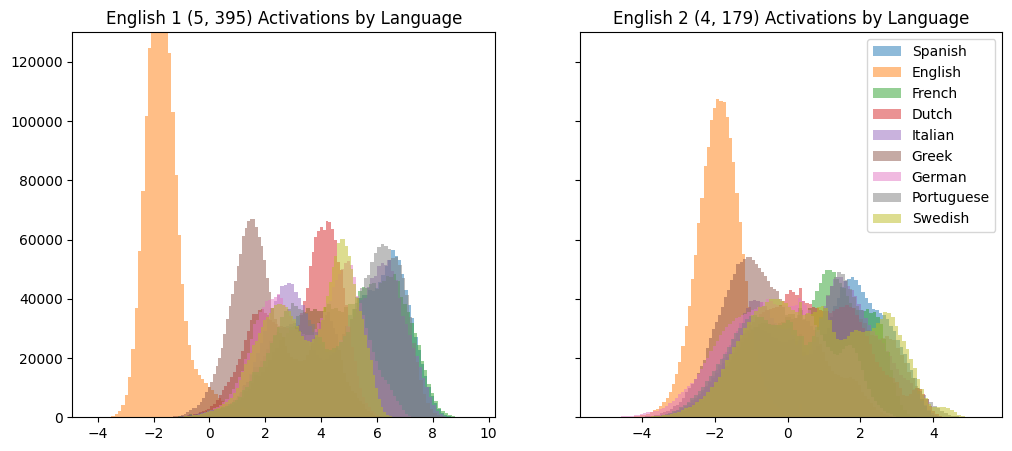

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i in range(len(language)):
    l = language_id[i]
    ax1.hist(activation_df_english1.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax1.set_title("English 1 (5, 395) Activations by Language");


for i in range(len(language)):
    l = language_id[i]
    ax2.hist(activation_df_english2.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=language[i]);
ax2.set_title("English 2 (4, 179) Activations by Language");
ax1.set_ylim(0, 130000);
ax2.legend();

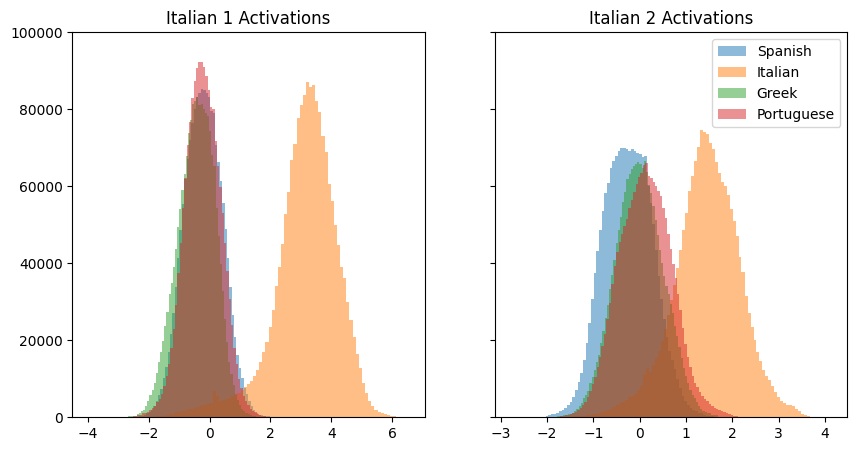

In [208]:
overlap_lang = ['Spanish','Italian', 'Greek', 'Portuguese']
overlap_id = [1, 5, 6, 8]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

for i in range(len(overlap_lang)):
    l = overlap_id[i]
    ax1.hist(activation_df_italian1.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=overlap_lang[i]);
ax1.set_title('Italian 1 Activations');

for i in range(len(overlap_lang)):
    l = overlap_id[i]
    ax2.hist(activation_df_italian2.query('language_id == @l and token > 1')['activation'], bins=100, alpha=0.5, label=overlap_lang[i]);
ax2.set_title('Italian 2 Activations');

ax1.set_ylim(0, 100000)
ax2.legend();

In [62]:
italian_df1 = activation_df_italian1.query('language_id == 5 and token > 1')
no_italian_df1 = activation_df_italian1.query('language_id != 5 and token > 1')
italian_df2 = activation_df_italian2.query('language_id == 5 and token > 1')
no_italian_df2 = activation_df_italian2.query('language_id != 5 and token > 1')

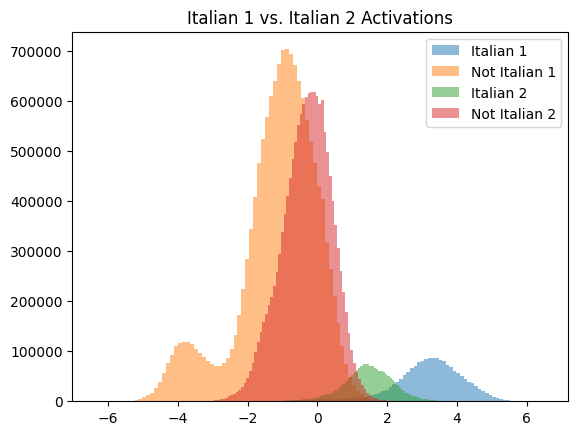

In [157]:
plt.hist(italian_df1['activation'], bins=100, alpha=0.5, label= 'Italian 1');
plt.hist(no_italian_df1['activation'], bins=100, alpha=0.5, label='Not Italian 1');
plt.hist(italian_df2['activation'], bins=100, alpha=0.5, label= 'Italian 2');
plt.hist(no_italian_df2['activation'], bins=100, alpha=0.5, label='Not Italian 2');
plt.title('Italian 1 vs. Italian 2 Activations');
plt.legend();

In [213]:
# @ aproximately 1, for italian 1 neuron, it could be either italian or not italian 50/50 chance
np.array(no_italian_df2.query('activation == 1')['string'])

array(['a', ' Rep', ' S', ' g', ' en', ' v', 'ya', ' dra', ' hon', ' in',
       'sta', ' av', ' g', ' från', ' under', ' här', ' av', ' gem',
       ' off', ' v', ' res', ' ', 'fe', 'sk', ' måste', 'lig', 'a', 'arl',
       ' en', ' sam', ' v', ' v', 'liga', ' ', ' inform', ' v', 'g', 'år',
       ' av', 'ire', ' gem', ' av', ' st', ' en', 'kä', ' in', 'rs',
       ' från', ' till', ' all', ' Herr', ' alla', 'mp', ' all', ' dra',
       'vare', ' ap', ' ', ' rest', 'är', ' här', ' ny', 'a', ' över',
       ' ann', 'ligt', 'amma', ' g', ' av', 'liga', ' n', ' hel', ' alla',
       ' S', ' av', ' i', 'ella', ' av', 'amma', 'DE', 'fe', 't', 'st',
       ' från', 'na', 'iska', ' ho', ' In', 'ende', ' sam', ' över',
       ' över', 'ande', ' sin', ' från', ' av', ' av', 'ria', ' rel',
       ' ins', 'rs', 'j', 'rs', ' per', ' gem', 'iska', ' av', ' Under',
       ' de', ' under', ' här', ' I', ' av', ' av', 'amma', ' I', ' av',
       ' de', 'ande', 'a', ' från', '\n', ' s', ' De', ' in', 

In [ ]:
# plot negative activation in correct lang id
plt.hist(italian_df1.query('activation and language_id == 2'), bins=100, alpha=0.5, label= 'italian 1');

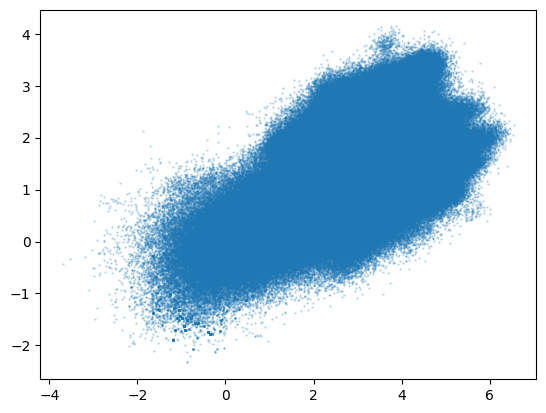

In [106]:
# want to know what the right sparse area is...
plt.scatter(italian_df1['activation'], italian_df2['activation'], s=.5, alpha=0.25, label='italian');

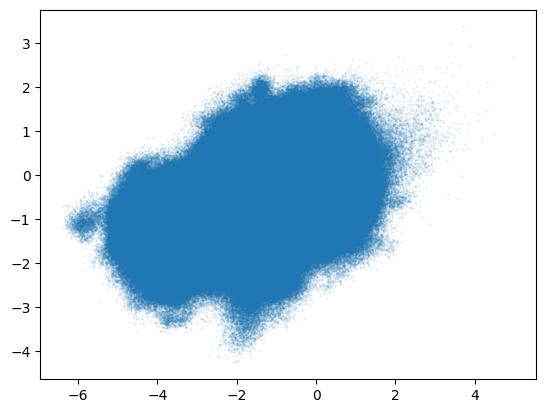

In [103]:
plt.scatter(no_italian_df1['activation'], no_italian_df2['activation'], s=.5, alpha=0.25, label='italian');

In [147]:
# put the two dataframes together



combined_df = pd.concat([italian_df1, italian_df2])

In [148]:
combined_df

,token,activation,language_id,string
12671489,4478,-0.868164,5,init
12671490,74,-0.015114,5,i
12671491,391,-0.265625,5,r
12671492,7821,-0.331055,5,inv
12671493,2886,-0.046204,5,ii
...,...,...,...,...
14789115,358,0.886230,5,em
14789116,423,0.461182,5,end
14789117,12263,1.442383,5,amento
14789118,390,0.849609,5,or


In [101]:
italian_df1.query('activation > -2 and activation > -1.8')

,token,activation,language_id,string
12671489,4478,-0.868164,5,init
12671490,74,-0.015114,5,i
12671491,391,-0.265625,5,r
12671492,7821,-0.331055,5,inv
12671493,2886,-0.046204,5,ii
...,...,...,...,...
14789115,358,1.596680,5,em
14789116,423,2.474609,5,end
14789117,12263,1.760742,5,amento
14789118,390,2.513672,5,or


In [100]:
# italian_df2.query('string == "ijn"')
italian_df2.query('activation > 2 and activation < 2.5')

,token,activation,language_id,string
12671508,14804,2.275391,5,della
12671512,1327,2.261719,5,non
12671515,339,2.037109,5,se
12671518,303,2.173828,5,im
12671520,994,2.056641,5,ent
...,...,...,...,...
14789087,1821,2.195312,5,men
14789094,1073,2.076172,5,di
14789103,1073,2.007812,5,di
14789106,936,2.052734,5,to


In [75]:
italian_df1['activation'].corr(italian_df2['activation'])

0.4628012543581771

In [76]:
no_italian_df1['activation'].corr(no_italian_df2['activation'])

0.40017355394393206

In [8]:
# A precomputed dataframe of token summaries for each neuron in the activation subset
# That is, for each neuron, summary statistics of the activations for each token in the dataset
# Note, you can compute this from the activation df above (it just takes a min so I precomute them all)
token_summary_df

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
0,3,1817,0,2554670.0,0.561059,0.008726,0.545293,0.553794,0.560103,0.566598,0.597284,<|endoftext|>
1,3,1817,1,36952.0,0.299034,0.000000,0.299034,0.299034,0.299034,0.299034,0.299034,<|padding|>
2,3,1817,2,7560.0,0.635129,0.916840,-1.554824,-0.047136,0.274229,1.581480,2.284389,!
3,3,1817,3,4319.0,-0.109521,0.417370,-1.496936,-0.369561,-0.169651,0.106246,1.965059,""""
4,3,1817,6,1477.0,-0.909288,0.428432,-2.109614,-1.211543,-0.916505,-0.624188,0.751484,%
...,...,...,...,...,...,...,...,...,...,...,...,...
319465,5,395,50247,41.0,6.663058,0.341653,5.552427,6.475464,6.683538,6.915891,7.219525,itons
319466,5,395,50249,4.0,2.785028,1.017241,1.653050,2.069474,2.862140,3.577694,3.762785,Tus
319467,5,395,50274,1.0,-1.269750,NaN,-1.269750,-1.269750,-1.269750,-1.269750,-1.269750,
319468,5,395,50275,25.0,3.140679,1.563092,-1.036697,2.483183,3.323091,4.373838,5.261631,


In [9]:
# For the particular neuron we are currently looking at
token_summary_df.query('layer == @layer_ix and neuron == @neuron_ix')

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
0,3,1817,0,2554670.0,0.561059,0.008726,0.545293,0.553794,0.560103,0.566598,0.597284,<|endoftext|>
1,3,1817,1,36952.0,0.299034,0.000000,0.299034,0.299034,0.299034,0.299034,0.299034,<|padding|>
2,3,1817,2,7560.0,0.635129,0.916840,-1.554824,-0.047136,0.274229,1.581480,2.284389,!
3,3,1817,3,4319.0,-0.109521,0.417370,-1.496936,-0.369561,-0.169651,0.106246,1.965059,""""
4,3,1817,6,1477.0,-0.909288,0.428432,-2.109614,-1.211543,-0.916505,-0.624188,0.751484,%
...,...,...,...,...,...,...,...,...,...,...,...,...
31942,3,1817,50247,41.0,0.529453,0.102206,0.244133,0.465410,0.530406,0.599382,0.715900,itons
31943,3,1817,50249,4.0,1.727137,0.588118,0.850007,1.660550,1.996023,2.062610,2.066496,Tus
31944,3,1817,50274,1.0,-1.166253,NaN,-1.166253,-1.166253,-1.166253,-1.166253,-1.166253,
31945,3,1817,50275,25.0,-0.556077,0.555612,-1.696393,-0.935205,-0.738400,-0.000400,0.362153,


In [10]:
# Italian is 5 (see language_id.py)
activation_df.groupby('language_id')['activation'].mean().sort_values(ascending=False)

language_id
9    1.879117
4    0.789619
7    0.357577
5    0.078371
8   -0.015340
3   -0.072993
2   -0.258616
1   -0.283804
6   -0.713034
Name: activation, dtype: float32

In [49]:
# pandas groupbys are powerful, I use them a lot
# .describe() is another nice function
# As an exercise reproduce the table above using these two functions

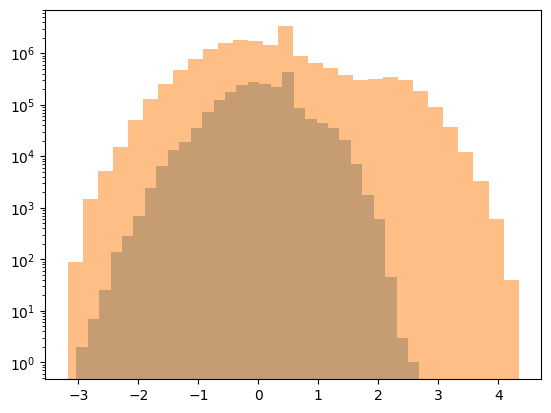

In [11]:
# We want to understand what is in the right tail of the orange distribution
plt.hist(activation_df.query('language_id == 5').activation.values, bins=30, label='italian', alpha=0.5)
plt.hist(activation_df.query('language_id != 5').activation.values, bins=30, label='not', alpha=0.5)
plt.legend
plt.yscale('log')

In [12]:
# Note you can recover where these occured by looking at the index of the activation df
top_right_tail = activation_df.query('language_id != 5').sort_values('activation', ascending=False).head(10)
top_right_tail

,token,activation,language_id,string
3277865,762,4.335938,9,under
3171503,762,4.296875,9,under
2713850,762,4.246094,9,under
3631538,762,4.234375,9,under
3827783,762,4.230469,9,under
3492271,762,4.222656,9,under
3778137,762,4.210938,9,under
2509197,762,4.199219,9,under
2296937,762,4.183594,9,under
3848989,762,4.171875,9,under


In [16]:
top_right_tail_fds_row = int(top_right_tail.index.values[6] // ctx_len)
sequence = feature_dataset[top_right_tail_fds_row]['tokens'] # Just look at first row

# TODO: don't include padding and end of text tokens (done)
token_list = [decoded_vocab[t.item()] for t in sequence if t > 1]
activation_list = [a.item() for a in activations[top_right_tail_fds_row]]

from circuitsvis.tokens import colored_tokens
colored_tokens(token_list, activation_list)

In [63]:
# According to chatGPT this is Italian! Success!

In [52]:
activation_df.query('language_id != 5').groupby('token')['activation'].mean().sort_values(ascending=False).head(10)

token
24268    2.511393
2089     2.501434
20889    2.244141
30975    2.181641
41527    2.080078
21622    2.059896
46161    2.052775
26027    1.907715
41764    1.887500
27522    1.834185
Name: activation, dtype: float32

## Happy hacking!

IndexError: string index out of range

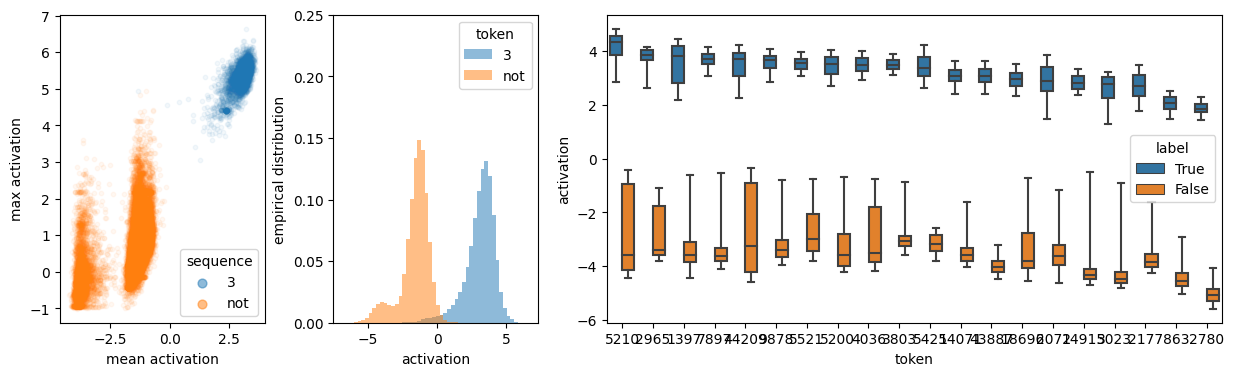

In [25]:
from probing_datasets.language_id import *
from analysis.context_neurons import plot_context_neuron_row
full_name_to_class_id = {v: TOP_NATURAL_LANGS[k] for k, v in NATURAL_LANGS_UNABBREVIATED.items() if k in TOP_NATURAL_LANGS}
fds_len = len(feature_dataset)

for ix, row in neuron_df.iloc[[4, 6, 0, 7, 1, 2, 3, 5]].iterrows():
    l, n, f = row.layer, row.neuron, row.feature
    class_id = full_name_to_class_id[f]
    neuron_activation_df = pd.DataFrame({
        'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
        'activation': act_subset_dict[(l, n)].flatten().numpy().astype(np.float32),
        'label': repeat(feature_dataset['class_ids'], 'b -> b l', l=512).flatten().numpy() == class_id,
        'seq_ix': repeat(np.arange(fds_len), 'b -> b l', l=512).flatten().astype(np.uint32)
    })
    activation_df = neuron_activation_df.loc[(neuron_activation_df['token'].values > 1)].reset_index(drop=True)
    plot_context_neuron_row(activation_df, f, l, n, "name");

UndefinedVariableError: name 'label' is not defined

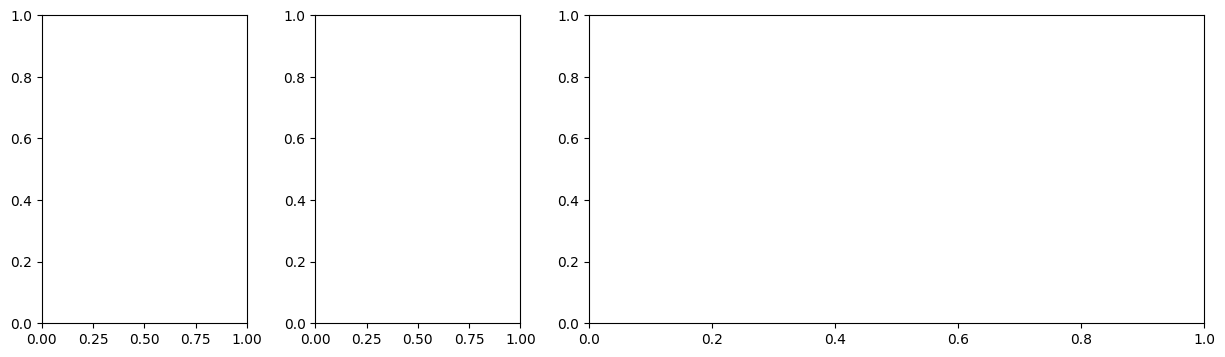

In [29]:

# Compute activations for each dataset
neuron_activation_df1 = activation_df_swedish1.query('language_id == 4')
neuron_activation_df2 = activation_df_swedish2.query('language_id == 4')

# Plot the activations for both datasets
for ix, row in neuron_df.iloc[[4, 6, 0, 7, 1, 2, 3, 5]].iterrows():
    l, n, f = row.layer, row.neuron, row.feature
    class_id = full_name_to_class_id[f]
    
    activation_df1 = neuron_activation_df1.loc[(neuron_activation_df1['token'].values > 1)].reset_index(drop=True)
    activation_df2 = neuron_activation_df2.loc[(neuron_activation_df2['token'].values > 1)].reset_index(drop=True)
    
    plot_context_neuron_row(activation_df1, f, l, n, "name")


In [15]:
from scipy.spatial.distance import cosine

def neuron_similarity(df1, idx1, df2, idx2):
    # Extract the data for the two neurons
    n1 = df1.iloc[idx1]
    n2 = df2.iloc[idx2]

    # Compute the cosine distance between the activation vectors
    activation_dist = cosine(n1['activation'], n2['activation'])

    # Compute the hamming distance between the tokens
    token_dist = np.hamming(n1['token'], n2['token'])

    # Compute the hamming distance between the language ids
    lang_dist = np.hamming(n1['language_id'], n2['language_id'])

    # Compute the cosine distance between the string embeddings
    string_dist = cosine(n1['string'], n2['string'])

    # Compute the overall distance as a weighted sum
    overall_dist = 0.5 * activation_dist + 0.2 * token_dist + 0.2 * lang_dist + 0.1 * string_dist

    # Compute the similarity as the inverse of the distance
    similarity = 1 - overall_dist

    return similarity

similarity = neuron_similarity(df1=activation_df_swedish1, idx1=0, df2=activation_df_swedish2, idx2=0)



ValueError: Input vector should be 1-D.

In [21]:
from scipy.stats import pearsonr

# Select two neurons from the activation dataframe

# Compute Pearson correlation coefficient between the two neurons based on activation values
corr, _ = pearsonr(activation_df_german1.query('language_id == 9')['activation'], activation_df_german2.query('language_id == 9')['activation'])

print(f"Pearson correlation coefficient between german neurons: {corr}")

from sklearn.metrics import jaccard_score

# Select two neurons from the activation dataframe
neuron1 = activation_df_german1.query('language_id == 9')
neuron2 = activation_df_german2.query('language_id == 9')

# Compute Jaccard similarity between the two neurons based on token values
similarity = jaccard_score(neuron1['token'], neuron2['token'], average='weighted')

print(f"Jaccard similarity between german neurons: {similarity}")

from scipy.spatial.distance import euclidean

# Compute Euclidean distance between the two neurons based on activation values
dist = euclidean(neuron1['activation'], neuron2['activation'])

print(f"Euclidean distance between german neurons: {dist}")


Pearson correlation coefficient between german neurons: -0.13468099752708665
Jaccard similarity between german neurons: 1.0
Euclidean distance between german neurons: inf


In [20]:
from sklearn.metrics import mutual_info_score

# Assume activations_1 and activations_2 are arrays containing the activations of two neurons
mi = mutual_info_score(activation_df_german1.query('language_id == 9')['activation'], activation_df_german2.query('language_id == 9')['activation']);
print(f"Mutual information between neuron 1 and neuron 2: {mi}")

/Users/katherineharvey/sparse-probing-4/sparprob/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Mutual information between neuron 1 and neuron 2: 3.280122645145337


In [23]:
cos_sim = np.dot(activation_df_german1.query('language_id == 9')['activation'], activation_df_german2.query('language_id == 9')['activation']) / (np.linalg.norm(activations_1) * np.linalg.norm(activations_2))
print(f"Cosine similarity between neuron 1 and neuron 2: {cos_sim}")



Cosine similarity between neuron 1 and neuron 2: nan


/var/folders/zl/vrkthn715j97ns3mht1gpfm80000gn/T/ipykernel_9488/236180300.py:1: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(activation_df_german1.query('language_id == 9')['activation'], activation_df_german2.query('language_id == 9')['activation']) / (np.linalg.norm(activations_1) * np.linalg.norm(activations_2))


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# select the activations for Swedish language only
swedish1 = activation_df_swedish1.query('language_id == 4')
swedish2 = activation_df_swedish2.query('language_id == 4')

# create a matrix of activation values, where rows represent tokens and columns represent neurons
swedish1_mat = swedish1.pivot(index='seq_ix', columns='neuron', values='activation')
swedish2_mat = swedish2.pivot(index='seq_ix', columns='neuron', values='activation')

# add a new column to the dataframes with the sequence index (assuming the index is a range of integers)
swedish1['seq_ix'] = swedish1.index.values
swedish2['seq_ix'] = swedish2.index.values

# calculate the correlation matrix between the two activation matrices
corr_mat = swedish1_mat.corrwith(swedish2_mat, axis=1)

# create the heatmap
sns.heatmap(corr_mat.values.reshape(1,-1), cmap='coolwarm', center=0, annot=True, fmt=".2f", xticklabels=swedish1['seq_ix'], yticklabels=False)

# set the plot title and axis labels
plt.title('Correlation between neuron activations for Swedish language')
plt.xlabel('Sequence index')
plt.ylabel('')

# show the plot
plt.show()


KeyError: 'seq_ix'

ValueError: List of violinplot statistics and `positions` values must have the same length

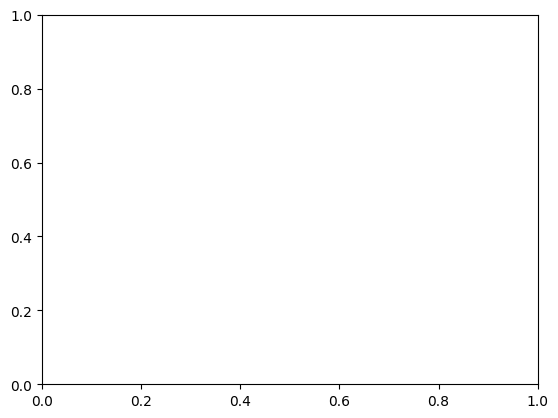

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# select the activations for Swedish language only
swedish1 = activation_df_swedish1
swedish2 = activation_df_swedish2

# create a dataframe that combines the activations for the two neurons
combined_df = pd.concat([swedish1, swedish2])

# create the violin plot
plt.violinplot(swedish1['activation'], swedish2['activation'])

# set the plot title and axis labels
plt.title('Distribution of neuron activations for Swedish language')
plt.xlabel('Neuron index')
plt.ylabel('Activation')

# show the plot
plt.show()


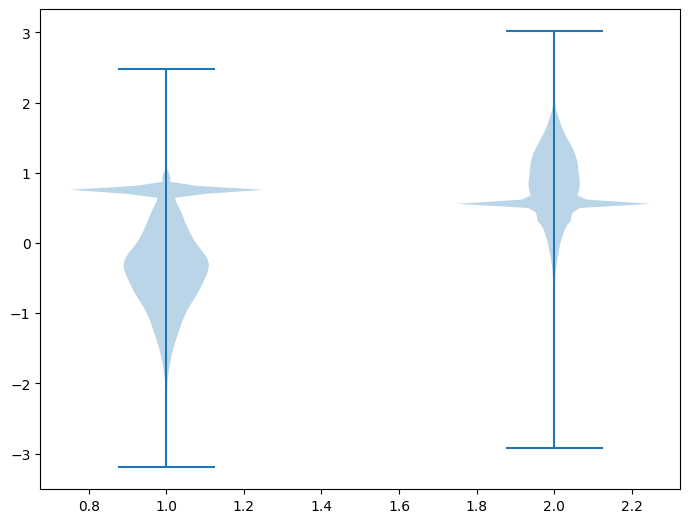

In [37]:
np.random.seed(10)
collectn_1 = activation_df_swedish1.query('language_id == 4')['activation']
collectn_2 = activation_df_swedish2.query('language_id == 4')['activation']

data_to_plot = [collectn_1, collectn_2]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

bp = ax.violinplot(data_to_plot)
plt.show()

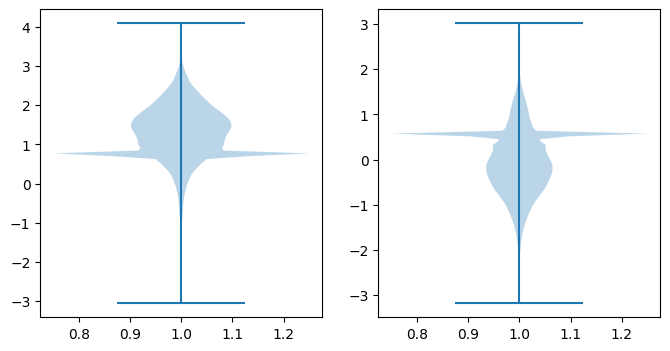

In [45]:
collectn_1 = activation_df_swedish1.query('language_id == 9')['activation']
data_to_plot = [collectn_1]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
bp = ax.violinplot(data_to_plot)

collectn_2 = activation_df_swedish2.query('language_id != 9')['activation']
data_to_plot = [collectn_2]

ax = axs[1]
bp = ax.violinplot(data_to_plot)

plt.show()

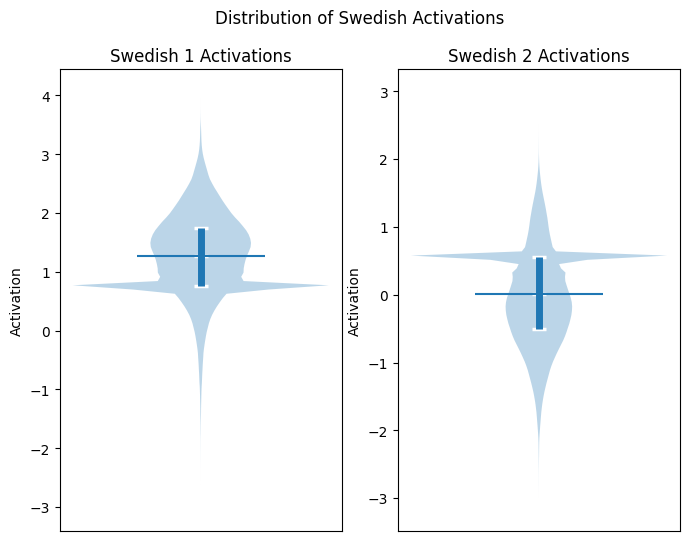

In [64]:
collectn_1 = activation_df_swedish1.query('language_id == 9')['activation']
collectn_2 = activation_df_swedish2.query('language_id != 9')['activation']
data_to_plot = [collectn_1, collectn_2]

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plot each violin plot
for i, ax in enumerate(axs):
    bp = ax.violinplot(data_to_plot[i], showmeans=False, showmedians=True, showextrema=False)
    quartiles = np.percentile(data_to_plot[i], [25, 50, 75])
    ax.scatter(np.ones(len(quartiles)), quartiles, marker='_', s=100, linewidth=2.5, color='white')
    ax.vlines(1, quartiles[0], quartiles[2], linestyle='-', lw=5)
    ax.set_xticks([])
    ax.set_ylabel('Activation')
    ax.set_title(f'Swedish {i+1} Activations')

# Set a main title for the entire plot
fig.suptitle("Distribution of Swedish Activations")

# Display the plot
plt.show()